# **Date: 18/02/2026:** Bias Detection pipeline



# Install necessary library

In [1]:
!pip install pandas scikit-learn fairlearn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


# Step 1: Create Sample Data

In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

data = pd.DataFrame({
    "income": np.random.normal(50000, 15000, 1000),
    "credit_score": np.random.normal(650, 50, 1000),
    "gender": np.random.choice(["Male", "Female"], 1000),
})

data["approved"] = (
    (data["income"] > 45000) &
    (data["credit_score"] > 600)
).astype(int)

# Introduce slight imbalance
data.loc[data["gender"] == "Female", "approved"] = \
    data.loc[data["gender"] == "Female", "approved"] * \
    np.random.choice([0,1], size=len(data[data["gender"]=="Female"]), p=[0.2,0.8])


# Step 2: Train the Model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data[["income", "credit_score"]]
y = data["approved"]

X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, data["gender"], test_size=0.3, random_state=42
)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# Step 3: Measure Accuracy by Group

In [4]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

metric_frame = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_test
)

print(metric_frame.by_group)


        accuracy
gender          
Female  0.905063
Male    0.992958


# Step 4: Measure Demographic Parity Difference

In [5]:
from fairlearn.metrics import demographic_parity_difference

dpd = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_test
)

print("Demographic Parity Difference:", dpd)


Demographic Parity Difference: 0.008468532715279031


# Step 5: Visualize the Gap

<Axes: xlabel='gender'>

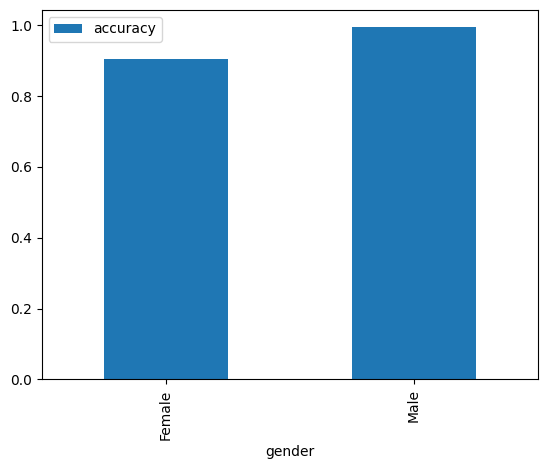

In [6]:
metric_frame.by_group.plot(kind="bar")
